In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
# focus on QA for electronics domain
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# stores answer as nested dict
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [4]:
# flatten with flatten() and convert splits to Pandas Dataframes
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [5]:
dfs['train'].sample(1)

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
1260,electronics,right,size,more reasonable,price,bd9a52715ed9ceabbc2115176d70e6d4,5,0.2,False,d4f9c6f9af5e705eb1bf6fa1b019624a,62326ee218c2e24b73f9b23f55208b72,B00DVFLJDS,This smartphone meets my needs.. The size is j...,How much is the price to pay?,[],[],[],[],[]


In [6]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


1. Questions are not always grammatically correct
2. Empty answers.text denotes "unanswerable" questions whose answer cannot be found in review

In [7]:
# take slice of span of text that corresponds to answer
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

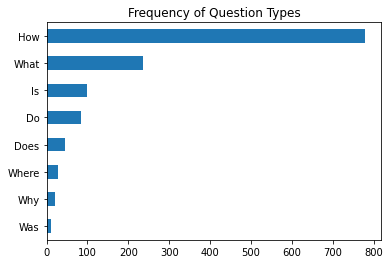

In [9]:
# get a feel of the questions in the training set; count questions that begin
# with a few common starting words
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
    
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

"How", "What" and "Is" are the most common. Let's look at some examples..

In [10]:
for question_type in ["How", "What", "Is"]:
    for question in (
    dfs["train"][dfs["train"].question.str.startswith(question_type)]
    .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


To extract answers from text, we must:
- Frame the supervised learning problem
- Tokenise and encode text for QA tasks
- Deal with long passages that exceeded a model's maximum content size

**Framing the Problem**: Span classification, must predict start and end labels that a model needs to predict. Can generally start with a model that has been fine-tuned on a large-scale QA dataset like SQuAD. We can actually start with a fine-tuned model as the structure of the labels are the same across datasets.

**Tokenising Text for QA**: 

In [11]:
# load MiniLM model checkpoint from HuggingFace Hub
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
# try to extract an answer from short passage of text
# for extractive, must provide (question, context) pairs
question = "How much music can this hold?"
context = """An MP3 is about 1MB/minute, so about 6000 hours depending on file size."""
# use tensors as we'll need them to run forward pass through model
inputs = tokenizer(question, context, return_tensors="pt")

In [13]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 14905,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

0 indicates a question token, 1 indicates a context token.

In [14]:
# decode input_ids tensor - to understand how tokenizer formats inputs for QA tasks
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1mb / minute, so about 6000 hours depending on file size. [SEP]


Has layout `[CLS] question tokens [SEP] context tokens [SEP]`; where first `[SEP]` token is determined by `token_type_ids`.

In [15]:
import torch
from transformers import AutoModelForQuestionAnswering

# instantiate model with QA head
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

# run inputs with forward pass
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-1.1224, -4.7834, -5.3935, -5.2447, -5.2899, -5.4980, -4.9885, -6.1783,
         -1.1224,  0.3651, -0.0807, -1.5551,  3.9556,  4.9206, -2.7833, -3.7461,
         -1.7211, -4.6096, -1.3769,  4.0256,  4.9715, -0.2477, -3.0354, -4.8180,
         -2.2386, -3.4867, -3.5462, -1.1224]]), end_logits=tensor([[-1.0707, -5.4840, -5.0304, -5.1770, -5.4496, -5.5120, -5.2013, -4.6178,
         -1.0707, -3.7223, -0.7583, -3.6969, -2.9205, -1.7346,  0.3122, -2.8688,
          4.8807,  0.2692, -3.1317, -3.2404,  0.8239,  5.6645, -0.2568, -4.8910,
         -3.1677, -0.0130,  1.6739, -1.0707]]), hidden_states=None, attentions=None)


Take the start and end logits to get the answer span.

In [16]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [17]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


We have a start and end logit associated with each input token. Positive logits is a more likely candidate for start and end token, so we can compute the argmax and slice the span from the inputs. That would give us our answer!

In [18]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


It works! Huggingface transformers conveniently wraps it all in a dedicated pipeline; we can instantiate and pass through our tokenizer and fine-tuned model as follows:

In [19]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/opt/conda/lib/python3.7/site-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.24360179901123047,
  'start': 37,
  'end': 47,
  'answer': '6000 hours'},
 {'score': 0.23150932788848877,
  'start': 16,
  'end': 47,
  'answer': '1MB/minute, so about 6000 hours'},
 {'score': 0.10571775585412979,
  'start': 16,
  'end': 26,
  'answer': '1MB/minute'}]

Also returns model's probability estimate (softmax over logits); and have multiple answers with `topk` parameter. Sometimes possible to have questions with no answer; in which case the model will assign a high start and end score to the `CLS` token, and pipeline maps this to an empty string.

In [20]:
pipe(question="Why is there no data?", context=context, handle_imposible_answer=True)

{'score': 0.00033265346428379416,
 'start': 10,
 'end': 70,
 'answer': 'about 1MB/minute, so about 6000 hours depending on file size'}

Taking start and end index can take out-of-scope answers by selecting tokens belonging to qestion instead of context. In practice, the pipeline computes best start-end indices combination subject to constraints, such as being in-scope; start indices precede end index and so on..

### Long Passages

In [21]:
# set retrn_overflowing=True in tokenizer to enable sliding window
# size of which is controlled by max_seq_length argument
# and size of stride is controlled by doc_stride
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                             return_overflowing_tokens=True, max_length=100,
                             stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [22]:
# now get list of input ids, one for each window; check tokens we have in each window
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [23]:
# can see where two windows overlap by decoding inputs
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



So we have intuition on how QA model can extract answers from text; now we can look at other components needed to build E2E QA pipeline. 

Typically QA systems retrieve based on retriever-reader architecture:
- *Retriever*: Retrieve relevant documents for a query; are categorised as either *sparse* or *dense*. Sparse retrievers use word frequencies to represent each document as a sparse vector. The relevancy of each query and a document is then determined by computing an inner product of the vectors. On the other hand, dense retrievers use encoders like transformers to represent the query and document as contextualised embeddings (which are dense vectors). Dense vectors encode semantic meaning, so improve search accuracy by understanding query context.
- *Reader*: Is responsible for extracting an answer from the documents provided by the reader. Usually a reading comprehension model; though also exist are models that can generate free-form answers
    - There may be other post-processing of retriever to eliminate noisy documents

Also two more components in QA pipeline with Haystack (based on retriever-reader architecture, abstracts complexity involved in building these systems, and integrates tightly with HFTransformers).:
- *Document Store*: Document-oriented database that stores documents and metadata which are provided to the retriever at query time
- *Pipeline*: Combines all components of QA system to enable custom query flows, merging documents from multiple retrievers, and more.

We will use Elasticsearch as the search engine/document store as it has full-text search features.

In [24]:
# install ElasticSearch
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
# Popen() to spawn a new process, as we are inside a Jupyter notebook
# also run the subprocess in the background using chown shell
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elastisearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
# specify program we wish to execute; 
# PIPE creates a new pipe for standard output
# STDOUT collects errors in the same pipe
# preexec_fn specifies the subprocess id we wish to use
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
 stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until
!sleep 30

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
# test connection to local port 9200
!curl -X GET "localhost:9200/?pretty"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "name" : "86a4e7f7b413",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "FvXHlBcdSwmp0CsIECDopg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [27]:
!pip install farm-haystack

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.4/666.4 kB 10.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.4/381.4 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.7/219.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 71.8 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 8.2 MB/s eta 0:00:00
     ━━━

In [28]:
# instantiate document store
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# return document embedding for later use with dense retriever
# creates two indices by default; document for storing docs and
# label; for storing annotated answer spans
document_store = ElasticsearchDocumentStore(return_embedding=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Haystack's document stores expect a list of dictionaries with text and meta keys as follows:

```
{
 "text": "<the-context>",
 "meta": {
 "field_01": "<additional-metadata>",
 "field_02": "<additional-metadata>",
 ...
 }
}
```

The fields in `meta` can be used to apply filters during retrieval. We'll include `item_id` and `q_review_id` columns of SubjQA so we can filter by product and question ID, also the training split.

Then can loop through examples in each DataFrame and add them to the index with `write_documents()` method.

In [29]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [
        {"content": row["context"],
        "meta":{"item_id": row["title"], "question_id": row["id"],
        "split": split}} for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


Have loaded all reviews into an index! Will need a retriever to search the index; so can look at initialising one for Elasticsearch.

Will start with BM25: "Best Match 25"; an improved version of TF-IDF, and represents the question and context as sparse vectors that can be searched efficiently on Elasticsearch. 

BM25 measures how much matched text is about a search query and improves TF-IDF by saturating TF values quickly and normalising the document length so short documents are favoured over long ones.

In [30]:
# BM25 is used by default in ElasticsearchRetriever; initialise class with doc store
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

It's important to restrict the queries in our review-based QA to a single item, otherwise we would get item reviews that we don't care about.

Things like ASIN help us identify items uniquely.

In [31]:
item_id = "B0074BW614"
query = "Is it good for reading?"
# specified how many docs with top_k, applied a filter on item id and split keys
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]}
)

In [32]:
from pprint import pprint
print(len(retrieved_docs))
pprint(retrieved_docs[0])

3
<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}>


Can also see a `score` that Elasticsearch computed for its relevance to the query (high score = better match). Under the hood, Elasticsearch relies on Lucene for indexing and search, so uses Lucene's practical scoring function by default. 

First filters by boolean (does doc match the query?), then applies a similarity metric based on representing both the document and query as vectors.

Now we can retrieve relevant documents, we need to figure out a way to extract answers from them. This is where the reader comes in, so look at how we can load our MiniLM model in Haystack.

Two types of readers one can use to extract answers from a context:
- **FARMReader**: Based on deepset's FARM framework for fine-tuning and deploying transformers. Compatible with models trained using HF Transformers and can load models directly from HF Hub
- **TransformersReader**: Based on QA pipeline from HF Transformers. Suitable for running inference only.

Though both readers handle a model's weights in the same way, there are some differences in the way the predictions are converted to produce answers.

- In HF Transformers, the QA pipeline normalises the start and end logits with a softmax in each passage. So it is only meaningful to compare answer scores between answers extracted from the same passage, where probabilities sum to 1. So 0.9 in one passage is not necessarily better than 0.8 in another passage. In FARM, the logits are normalised so inter-passage answers can be compared more easily.
- TransormersReader sometimes predicts the same answers twice, but with different scores. This can happen in long contexts if the answer lies across two overlapping windows. In FARM, these duplicates are removed.

In [33]:
# use FARMReader as we'll be fine-tuning the reader later
from haystack.reader.farm import FARMReader

# specify MiniLM checkpoint; similar to HF Transformers
model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(
    model_name_or_path=model_ckpt, progress_bar=False,
    max_seq_len=max_seq_length, doc_stride=doc_stride,
    return_no_answer=True
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: It is also possible to fine-tune a model directly in HF Transformers then load in TransformersReader to run inference.

In [34]:
# behaviour of sliding window is controlled by max_seq_length and 
# doc_stride. Test reader on example from earlier
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.829152584075928, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5138804167509079, 'context': 'An MP3 is about 1MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 37, 'end': 47}], 'offsets_in_context': [{'start': 37, 'end': 47}], 'document_id': '4dc55d90fb64f6d8b34472666e73a16d', 'meta': {}}>]}


Tie together with Haystack pipeline; allows us to combine retrievers, readers and more components as a graph that can be customised for each use-case.

In [35]:
from haystack.pipeline import ExtractiveQAPipeline

# want to extract answers; so use ExtractiveQAPipeline, which takes a single
# retriever-reader pair
pipe = ExtractiveQAPipeline(reader, es_retriever)

In [36]:
n_answers = 3
# run() specifies how query flow should be executed
# also specify filter over item. 
preds = pipe.run(query=query, 
                 params={
                     "Retriever": {"top_k": 3}, 
                     "Reader": {"top_k": n_answers},
                     "filters": {"item_id": [item_id], "split": ["train"]}
                 })
# Retrieve and return the extracted answers
print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}... ")
    print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t... 



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la... 



Answer 3: 
Review snippet: ...None... 





So we have an E2E QA system for Amazon product reviews! Retriever, reader! Good start, but we could do better. Need to get some metrics to quantify the performance of the retriever and reader.

### Improving Our QA Pipeline

In practice, it doesn't matter how good reader is if retriever can't find relevant documents! Retriever sets an upper bound on performance of whole QA system, so important to ensure it's doing a good job. Look at some common metrics to evaluate the retriever so can compare the performance of sparse and dense representations:

- **Recall**: Fraction of all relevant documents retrieved. "Relevant" means whether answer is present in a text passage or not, so number of times an answer appears in top-k docs returned by retriever
- **Mean Average Precision (mAP)**: Rewards retrievers that can place the correct answers higher up in document ranking

In Haystack, we can use two methods:
- Built in `eval()` method. Can be used for both open and closed domain QA, but not for datasets like SubjQA where each document is paired with a single product and we need to filter by Product ID for every query
- Build a custom pipeline that combines `EvalRetriever` class. This enables implementation of custom metrics and query flows

In [37]:
# opt for secnd approach; each node in Pipeline graph represents a class
# that takes some inputs and produces some outputs via a run() method
class PipelineNode:
    def __init__(self):
        self.outgoing_edges = 1
        
    # kwargs is outputs from previous node in graph
    # manipulated with run() to return tuple of outputs for next node
    # along with name for outgoing edge attribute that indicates num of outputs
    # from the node
    def run(self, **kwargs):
        ...
        return (outputs, "outgoing_edge_name")

Need to evaluate the retriever, so will use `EvalRetriever` class whose run() method keeps track of which documents have answers that match the ground truth.

In [38]:
from haystack.pipeline import Pipeline
from haystack.nodes.evaluator import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        # each node has a name and a list of inputs
        # in most cases each node has a single outgoing edge so just need to
        # include name of previous node in input
        pipe.add_node(component=self.retriever, name="ESRetriever", inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever", inputs=["ESRetriever"])
        self.pipeline = pipe
        
pipe = EvalRetrieverPipeline(es_retriever)

Pass in some queries and their corresponding answers. We'll add the answers to a dedicated label index on our document store. Haystack provides a Label object that represents the answer spans and their metadata in a standardized fashion. We'll first create a list of Label objects by looping over each question in the test set and extract the matching answers and additional metadata.

In [39]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], document=Document(row['context']), 
                answer=Answer(answer), id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False
            )
            labels.append(label)
    # Pupulate labels for questions without answers
    else:
        label = Label(
            query=row["question"], document=Document(row['context']), 
            answer=Answer(""), id=i, origin=row["id"],
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True
        )
        labels.append(label)

In [40]:
labels[0]

<Label: {'id': '05eeb8b1-bfb9-429a-b7f1-8fb72d4d0cbd', 'query': 'What is the tonal balance of these headphones?', 'document': {'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic.  The pads t

Contains QA pair and unique ID to filter the document store per question. Also added the product_id to metadata so can filter labels by product.

In [41]:
# write to label index on Elasticsearch
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} question-answer pairs""")

Loaded 358 question-answer pairs


In [61]:
# build mapping between question IDs and corresponding answers that we can pass to pipeline
# aggregate all QA pairs associated with a unique ID. 
# Return list of MultiLabel objects; only get one element since we filter by question ID

labels_agg = document_store.get_all_labels_aggregated(
 index="label",
 open_domain=True,
 aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

DocumentStoreError: Failed to create labels from the content of index 'label'. Are you sure this index contains labels?

In [67]:
# feeder function that feeds each qa pair associated with product to evaluation pipeline
# and tracks the correct retrievals in our pipe object
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.question,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,
            labels=l,
            filters={"items_id": [l.meta["item_id"]], "split": ["test"]}
        )
run_pipeline(pipe, top_k_retriever=3)
print(f"Recall@3: {pipe.eval_retriever.recall:.2f}")

Notice that we've picked a specific value for top_k_reriever to specify number of documents to retrieve. In general, increasing this parameter will improve the recall, but at the expense of providing more documents to the reader and slowing down end-to-end pipeline

In [65]:
# create function that loops over several k and computes recall across whole test set of each k
def evaluate_retriever(retriever, topk_values=[1,3,5,10,20]):
    topk_results = {}
    
    for topk in topk_values:
        # create pipeline
        p = EvalRetrieverPipeline(retriever)
        # loop over each QA pair in test set
        run_pipeline(p, top_k_retriever=topk)
        # get metrics
        topk_results[topk] = {"recall": p.eval_retriever.recall}
    
    return pd.DataFrame.from_dict(topk_results, orient="index")

es_topk_df = evaluate_retriever(es_retriever)

In [ ]:
# plot results to see how recall improves as we increase k

def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([es_topk_df], ["BM25"])

Inflection point around k=5 and almost perfect recall from k=10 onwards.. Now, look at retrieving documents with dense vector trechniques.

**Dense Passage Retrieval**

Smaller k? Then less documents to reader and reduce latency of QA pipeline. Limitation of sparse retrievers like BM25 is that they can fail to capture relevant documents if user query has terms that don't exactly match those of review. 

An alternative is dense embeddings to represent question and document. Current SOTA is *Dense Passage Retrieval (DPR)*. 

Main idea is to use two BERT models as encoders for question and passage, which map input text into d-dimensional vector representation of `[CLS]` token; then take dot product similarity of question vector with passage vector, then go into document store.

In Haystack, we can initialise a retriever for DPR in similar way we did for BM25. We also need to pick BERT encoders for question and passage. These encoders are trained by giving them questions with relevant (positive) passages and irrelevant (negative) passages, where the goal is to learn that relevant question-passage pairs have a higher similarity. For this, we'll use encoders that have been fine-tuned on NQ corpus in this way:

In [62]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False # false as concatenating doc title doesn't provide additional info
    # as we filter per product
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [63]:
# iterate over indexed documents in elasticsearch index
# and apply encoders to update embedding representation
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

In [68]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df, ["BM25", "DPR"]])

NameError: name 'labels_agg' is not defined

DPR does not provide a boost in recall and saturates around k=3. 

Similarity search can be sped up using FAISS as document store; and DPR performance can be improved by fine-tuning on target domain. Haystack has multiple tutorials for this.

So now we can look at evaluating the reader.

### Evaluating the Reader

Two main metrics to evaluate readers:
- *Exact Match (EM)*: A binary metric that gives EM = 1 if the characters are in the predicted and ground truth answers match exactly, and EM = 0 otherwise. If no answer expected, the model gets EM = 0 if it predicts any text at all.
- *$F_1-score$*: Measures the harmonic mean of the precision and recall.

In [ ]:
from farm.evaluation.squad_evaluation import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

Under the hood, these functions first normalise the prediction and label by removing punctuation, fixing whitespace, and converting to lowercase. The normalised strings are tokenised as a bag-of-words before computing the metric at the token level.

From this example we can see EM is a sricter metric than F1 score, adding a single token to prediction gives EM a zero; however, F1 can fail to catch truly incorrect answers. e.g.

In [ ]:
pred = "about 6000 dollars"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

So relying on F1 score is misleading, so tracking both metrics is a good strategy to balance trade-off between underestimating (EM) and overestimating (F1-score) model performance.

Generally, there are multiple valid answers per question, so metrics are calculated for each possibleQA pair in evaluation set and best score is selected over all possible answers. Overall EM and F1 scores are obtained by averaging over individual scores of each QA pair.

To evaluate reader, we will create a pipeline with two nodes: a reader node to evaluate the reader, will use EvalReader class that takes predictions from reader and computes corresponding EM and F1 scores. Tocompare with SQuAD evaluation, we'll take the best answers for each query with top_1_em and top_1_f1 metrics stored in EvalAnswers:

In [ ]:
from haystack.eval import EvalAnswers

def evaluate_reader(reader):
    score_keys = ['top_1_em', 'top_1_f1']
    # false so retriever always passes context to reader (as in SQuAD evaluation)
    eval_reader = EvalAnswers(skip_incorrect_retrieval=False)
    pipe = Pipeline()
    pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
    pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])
    
    for l in labels_agg:
        doc = document_store.query(l.question,
                                  filters={"question_id":[l.origin]})
        _ = pipe.run(query=l.question, documents=doc, labels=l)
        
    return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

In [ ]:
# print scores after running through every question
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc="upper left")
    plt.show() 
    
plot_reader_eval(reader_eval)

Fine-tuned model performs significantly worse on SubjQA than on SQuAD 2.0, where MiniLM achievesEM and F1 of 76.1 and 79.5 respectively. 

One reason for performance drop is that customer reviews are different from Wikipedia articles the SQuAD 2.0 dataset is generated from, and the language they use is often informal.

Another reason is likely the inherent subjectivity of our dataset, where both questions and answers differ from the factual information contained in Wikipedia. 

Look at how to fine-tune a model on a dataset to get better results with domain adaptation.

### Domain Adaptation

Although models fine-tuned on SQuAD generise well to other domains, we see for SubjQA the EM and F1 scores of our model were much worse than for SQuAD. We have observed this in other extractive QA datasets and is understood as evidence that transformer models are adept at overfitting to SQuAD.

The most straightforward way is to fine-tune MiniLM model further on SubjQA training set. The FARMReader has a train() method that is designed for this purpose and expecs the data to be in SQuAD JSON format, where all the QA pairs are grouped together for each item.

> Data
>> Paragraphs
>>> Qas
>>>> Answers

Quite a complex data format, so we'll need a few functions and some Pandas to help do the conversion.

In [ ]:
# implement a function that can create the paragraphs array associated 
# with each product ID. Each element in array contains a single context (review)
# and a qas array of question-answer pairs.
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all QA pairs about a specific content
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review["id"], review_df["question"]))
        # build up qas array
        for qid, question in id2question.items():
            # filter for a single question id
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text":text, "answer_start":answer_start} 
                    for text, answer_start in zip(ans_tex, ans_start_idxs)
                ]
                is impossible=False
            else:
                answers = []
                is_impossible = True
            # add QA pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # add context and QA pairs to paragraphs
        paragraphs.append("qas": qas, "context": review)
    return paragraphs

In [ ]:
product = dfs["train"].query("title == ;B0001P4ZH")
create_paragraphs(product)

In [ ]:
# apply function to each product ID in dataframe of each split
# following func does this in electronics-{split}.json file

import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_daa = {}
        # create `paragraphs` or each product id
        groups = (df.groupby("title").apply(create_paragraphs).to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # save result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
    
convert_to_squad(dfs)

In [ ]:
# splits in right format, we can fine-tune
# first; specify location of train and dev splits and where to save fine-tuned model

train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

In [ ]:
reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
            train_filename=train_filename, dev_filename=dev_filename)

In [ ]:
# compare performance on test against baseline
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

Domain adaptation works! EM score increase 6x and F1 score doubles. Why not directly fine-tune on SubjQA train set? Because SubjQA has 1,295 examples while SQuAD has >100,000 so we may run into some overfitting. 

Nonetheless, we can look at the results of native fine-tuning, using the same language model used for fine-tuning baseline on SQuAD.

In [ ]:
# load model with FARMReader
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                          max_seq_len=max_seq_length, doc_stride=doc_stride,
                          return_no_answer=True)

In [ ]:
# fine-tune for one epoch
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
                   train_filename=train_filename)

In [ ]:
# include evaluation on test set
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

So fine-tuning on SubjQA results is much worse than fine-tuning on SQuAD and SubjQA.

Best practice to use cross-validation when evaluating transformers as they can be prone to overfitting. There are examples of cross-validation with SQuAD-formatted datasets in FARM repository.

## Evaluating Whole QA Pipeline

Now we know how to evaluate the reader and retriever components individually, we can tie them together to measure the overall performance of our pipeline. We'll need to augment our retriever pipeline with nodes for the reader and its evaluation. 

We've seen almost perfect recall at k=10, so we can fix this value and assess the impact it has on the reader's performance (as it will now receive multiple contexts per query compared to SQuAD-style evaluation):

In [ ]:
# initialise retriever pipeline
pipe = EvalRetrieverPipeline(es_retriever)

# add nodes for reader
eval_reader = EvalAnswers()
pipe.pipeline.add_node(component=reader, name="QAReader", inputs=["EvalRetriever"])
pipe.pipeline.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])

# Evaluate!
run_pipeline(pipe)

# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k, v in eval_reader.__dict__.items() if k in ["top_1_em", "top_1_fm"]
}

So we can see how the retriever has an effect on overall performance. Overall there's a degradation compared to matching the question-context pairs as is done in SQuAD style evaluation. This can be circumvented by increasing the number of possible answers the reader is allowed to predict.

Until now, we have only extracted answer spans from the context, but in general it could be bits and pieces of the answer are scattered throughout the document. We'd like our model to synthesize these fragments into a single answer. Look at generative QA to succeed at this task.

### Beyond Extractive QA

An alternative to extracting answers is to generate them with a pretrained language model. This is referred to as *abstractive* or *generative* QA; and has the potential to produce better-phrased answers that synthesize evidence across multiple passages. 

This is less mature than extractive QA but an exciting field of research. Current SOTA is *retrieval-augmented generation* (RAG); extending the classic retriever-reader architecture by swapping the reader for a *generator* and using DPR as the retriever. The generator is a pretrained seq2seq transformer like T5 or BART that receives latent vectors of documents from DPR and iteratively generates an answer based on the query and documents. Since DPR and generator are differentiable, can be trained E2E.

There are two types of RAG models to choose from:
- *RAG-Sequence*: Same retrieved document to generate a complete answer. In particular, the `top-k` documents from the retriever are fed to the generator, which produces an output sequence for each document and the result is marginalised to obtain the best answer
- *RAG-Token*: Can use a different document to generate each token in the answer, allowing the generator to synthesize evidence from multiple documents.

RAG-TOken models tend to perform better than RAG-Sequence, we can use token model fine-tuned on NQ as our generator.

In [ ]:
from haystack.generator.transforms import RAGenerator

# specify hyperparameters that control the text generation
generator = RAGenerator(
    model_name_or_path="facebook/rag-token-nq",
    embed_title=False, # don't embed titles since corpus is filtered per product id
    num_beams=5) # beam search num

In [ ]:
from haystack.pipeline import GenerativeQAPipeline

# tie retriever and generator with GenerativeQAPipeline
pipe = GenerativeQAPipeline(generator=generator, retriever=dpr-retriever)

In RAG, query encoder and generator are trained E2E while context encoder is frozen. In Haystack, the GenerativeQAPipeline uses the query encoder from RAGenerator and context encoder from DensePassageRetriever.

In [ ]:
# try some queries on Amazon Fire tablet
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(
        query=query, 
        top_k_generator=top_k_generator,
        top_k_retriever=5, 
        filters={"item_id":["B0074BW614"]}
    )
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")

In [ ]:
generate(answers(query))

Does suggest the subjective nature of the question confuses the generator

In [ ]:
generate_answers("What is the main drawback?")

We see a more factual question yields more sensible results. To get better results we could fine-tune RAG E2E on SubjQA.

## Conclusion

Two approaches to QA: Extractive and generative, and examine two retrieval algorithms: BM25 and DPR. Also domain adaptation can be a simple technique to boost QA system performance by a significant margin, as well as common metrics for evaluating such systems. We focused primarily on closed-domain QA, the techniques can be generalised to open-domain case. 

Recommend exploring generative QA once other approaches (search and extraction) have been exhausted, given its infancy. Also really think of what users need.

One exciting area is multimodal QA, QA over multiple modalities like text, tables and images. E.g. "What was the famous painting with two touching fingers completed?". Another area with practical business application is QA over knowledge graph, where nodes are real-world entities and edges are relationships, so one can use graph to answer questions about a missing element.

In order to successfully QA for real-world use cases, we need to apply tricks such as implementing a fast retrieval pipeline to make near real-time predictions. A few seconds of which can make a large difference in the customer experience.

Next chapter, we'll look at how to accelerate model predictions further!